In [1]:
# Import necessary PySpark modules
from pyspark.sql import SparkSession

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("trackpopularityAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 07:46:53 INFO SparkEnv: Registering MapOutputTracker
23/12/14 07:46:53 INFO SparkEnv: Registering BlockManagerMaster
23/12/14 07:46:53 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/14 07:46:53 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Load the dataset
df = spark.read.csv("gs://hive-final0/Database_to_calculate_Poularity.csv", header=True, inferSchema=True)

In [6]:
# Print the structure of the dataset
df.printSchema()

root
 |-- Number: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- position: integer (nullable = true)
 |-- uri: string (nullable = true)
 |-- track: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)



In [5]:
df.createOrReplaceTempView("df_table")

In [7]:
print("data table length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

data table length as before


+--------------+
|Dataset_Length|
+--------------+
|       1048575|
+--------------+



In [8]:
# how many unique songs are there in the dataset?
df.select(["Title","Artist"]).distinct().count()

11137

In [9]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))

Dataset Shape using spark syntax:
 (1048575, 8)


In [11]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [13]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 64.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
sns.set_palette('rainbow')
sns.set_style('whitegrid')
import plotly.express as px

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')
from sklearn.cluster import KMeans

In [15]:
from pyspark.sql.functions import col, year, to_timestamp

# Extract the year from the 'launched' column
popularity = df.withColumn("launched_year", year(col("date")))

# Filter out invalid years
popularity =popularity.filter((col("launched_year") >= 2017) & (col("launched_year") <= 2020) & (col("launched_year").isNotNull()))

# Group by year and select relevant columns for analysis
pop = popularity.groupBy("launched_year").agg({"position": "count", "number": "count"})

# Display the aggregated data
pop.show()

+-------------+-------------+---------------+
|launched_year|count(number)|count(position)|
+-------------+-------------+---------------+
|         2018|       291975|         291975|
|         2019|       292000|         292000|
|         2020|       248000|         248000|
|         2017|       216600|         216600|
+-------------+-------------+---------------+



In [16]:
from pyspark.sql.functions import col, format_number
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

# Convert relevant columns to numeric, handle missing values
df = df.withColumn("number", col("number").cast(DoubleType())).na.fill(0)
df = df.withColumn("position", col("position").cast(DoubleType())).na.fill(0)

# Convert string columns to timestamp
df = df.withColumn("date", to_timestamp(col("date"), "yyyy-MM-dd HH:mm:ss"))

# xtract year, month, and day from the timestamp columns interested 
df = df.withColumn("date_year", year(col("date")))
df = df.withColumn("date_month", month(col("date")))
df = df.withColumn("date_day", dayofmonth(col("date")))

In [17]:
# Print the structure of the dataset
df.printSchema()

root
 |-- number: double (nullable = false)
 |-- country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- position: double (nullable = false)
 |-- uri: string (nullable = true)
 |-- track: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- date_year: integer (nullable = true)
 |-- date_month: integer (nullable = true)
 |-- date_day: integer (nullable = true)



In [19]:
from pyspark.sql.functions import col, year, to_timestamp
# Extract the year from the 'date' column
popullarity = df.withColumn("launched_year", year(col("date")))

# Filter out invalid years
popullarity = popullarity.filter((col("title") != ' ') & (col("title").isNotNull()))

# Group by year and select relevant columns for analysis
pop = popullarity.groupBy("date_year").agg({"country": "count", "artist": "count"})

# Display the aggregated data
pop.show()

+---------+--------------+-------------+
|date_year|count(country)|count(artist)|
+---------+--------------+-------------+
|     2018|        291975|       291575|
|     2019|        292000|       292000|
|     2020|        248000|       248000|
|     2017|        216596|       216552|
+---------+--------------+-------------+



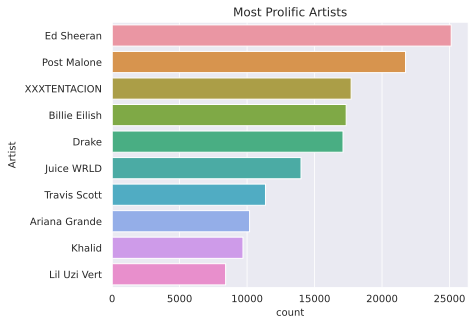

In [27]:
result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )
px.bar(result_df, y='Artist', x='count', title='Most Prolific Artists')
sns.barplot(data=result_df, y='Artist', x='count').set_title('Most Prolific Artists');

In [28]:
# select only the songs released in 2020
(df.filter(F.year(df['date']) == 2020)
   .select('Title', 'Artist','date', 'track')
   .distinct()
   .show(5, truncate=False)
)

+-----------------+-----------------------------------+-------------------+------------------------------------------------+
|Title            |Artist                             |date               |track                                           |
+-----------------+-----------------------------------+-------------------+------------------------------------------------+
| off the table   | Ariana Grande                     |2020-11-05 00:00:00| off the table  , Ariana Grande                 |
| Intentions      | Justin Bieber                     |2020-11-05 00:00:00| Intentions  , Justin Bieber                    |
| Sofia           | Clairo                            |2020-11-03 00:00:00| Sofia , Clairo                                 |
| Una Locura      | Ozuna, J Balvin, Chencho Corleone |2020-11-02 00:00:00| Una Locura , Ozuna, J Balvin, Chencho Corleone |
| hot girl bummer | blackbear                         |2020-11-02 00:00:00| hot girl bummer , blackbear                    |


In [29]:
# Most world wide realsed tracks.
query = """
SELECT country, COUNT(*) AS Tally
FROM df_table
GROUP BY country
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

+---------+------+
|  country| Tally|
+---------+------+
|   Global|280200|
|       UK|280200|
|      USA|280200|
|Argentina|207975|
+---------+------+



In [31]:
query = """
SELECT
      ROUND(Year(date)) AS year,
      artist, COUNT(artist)           AS counts
FROM  df_table
WHERE ROUND(Year(date), -1) IS NOT NULL
GROUP BY year, artist
ORDER BY COUNT(artist) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['year'])
            .orderBy('year')
            .show()
      )

+----+---------------+------+
|year|         artist|counts|
+----+---------------+------+
|2017|    Ed Sheeran |  9581|
|2018|  XXXTENTACION |  8538|
|2019| Billie Eilish |  9878|
|2020|    Juice WRLD |  7201|
+----+---------------+------+



In [ ]:
sound_features = ['artist[0]', 'artist[1]', 'artist[2]']
col_names = ['positions']
col_names.extend(sound_features)

df_music_features = (df.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
fig = px.line(df_music_features, x='position', y=sound_features, title='Song Characteristics Over the Decades')
fig.show()

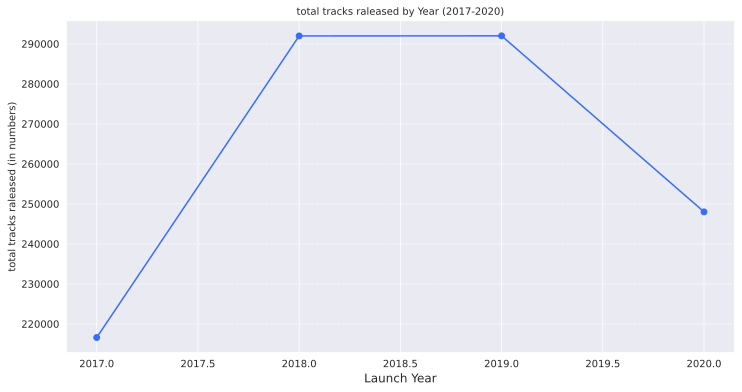

In [33]:
from pyspark.sql.functions import year, sum

# Select relevant columns for analysis
popularity = df.select("number", "date")

# Extract the year from the 'date' column
popularity = popularity.withColumn("date_year", year("date"))

# Add an additional filter for the years between 2017 and 2020
popularity = popularity.filter((popularity["date_year"] >= 2017) & (popularity["date_year"] <= 2020))

# Calculate the total track raleased by year
total_tracks_raleased = (
    popularity.groupBy("date_year")
    .agg((count("number")).alias("total_tracks_raleased"))
    .orderBy("date_year")
)

# Convert to Pandas for visualization
total_tracks_raleased_pd = total_tracks_raleased.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(total_tracks_raleased_pd["date_year"], total_tracks_raleased_pd["total_tracks_raleased"], marker='o', linestyle='-')

plt.xlabel("Launch Year", fontsize=12)
plt.ylabel("total tracks raleased (in numbers)", fontsize=10)
plt.title("total tracks raleased by Year (2017-2020)", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()